In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import IPython.display as disp
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from vector_quantize_pytorch import FSQ
from random import randint

In [2]:
class VectorQuantizedAutoencoder(nn.Module):
    def __init__(self, levels): 
        super().__init__()
        
        self.analysis_transform = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=2, stride=1, padding=1),
            nn.Conv2d(192, 192, kernel_size=6, stride=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.GELU(),
            nn.Conv2d(192, 192, kernel_size=6, stride=3, padding=1),
            nn.Conv2d(192, 512, kernel_size=6, stride=3, padding=1),
        )
        
        self.fsq = FSQ(levels)
        
        self.synthesis_transform = nn.Sequential(
            nn.ConvTranspose2d(512, 192, kernel_size=6, stride=3, padding=1),
            nn.ConvTranspose2d(192, 192, kernel_size=6, stride=3, padding=0),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.ConvTranspose2d(192, 192, kernel_size=6, stride=3, padding=0),
            nn.Conv2d(192, 3, kernel_size=2, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.analysis_transform(x)
        x, indices = self.fsq(x)
        x = self.synthesis_transform(x)

        return x.clamp(-1, 1), indices

In [4]:
def live_plot(x):
    plt.clf()
    plt.plot(x)
    disp.display(plt.gcf())
    disp.clear_output(wait=True)

In [5]:
dataset = load_dataset("danjacobellis/vimeo90k_triplet",split='train').with_format("torch")

Resolving data files:   0%|          | 0/71 [00:00<?, ?it/s]

In [ ]:
lr = 3e-4
seed = 1234
levels = [8, 5, 5, 5]
torch.random.manual_seed(seed)
model = VectorQuantizedAutoencoder(levels).to("cuda")
opt = torch.optim.AdamW(model.parameters(), lr=lr)
crop = transforms.RandomCrop(size=(256,256))

log_loss = np.array([])
for i_epoch in range(200):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    for i_batch, batch in enumerate(dataloader):
        x = batch['image'].to("cuda")
        x = x.to(torch.float)
        x = x/255
        x = x - 0.5
        x = x.permute(0, 3, 1, 2)
        x = crop(x)
        opt.zero_grad()
        out, indices = model(x)
        rec_loss = (out - x).abs().mean()
        rec_loss.backward()
        opt.step()
        log_loss = np.append(log_loss,np.log(rec_loss.detach().cpu().numpy()))
        live_plot(log_loss)
        torch.save({
            'epoch': i_epoch,
            'model_state_dict':  model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'log_loss': log_loss,
        }, f"vqvae_vimeo_checkpoint.pth")

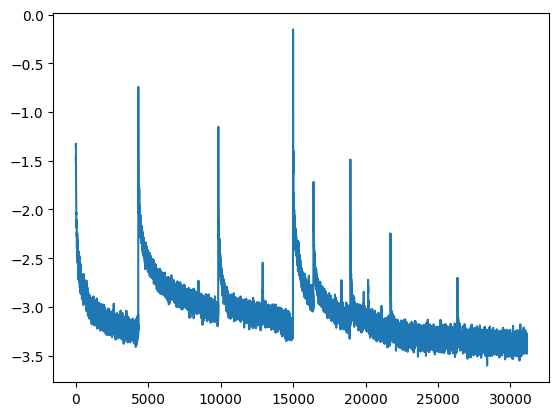

In [4]:
checkpoint = torch.load("vqvae_vimeo_checkpoint.pth")
plt.plot(checkpoint['log_loss'])